In [50]:
# THESE FIRST 3 IMPORTS ARE CUSTOM .py FILES AND CAN BE FOUND ON THE GITHUB and in the mlp_2020 folder
import visualize
import metrics_plots
from pipeline_components import DataSampleDropper, DataFrameSelector

import pandas as pd
import numpy as np
import scipy.stats as stats
import os, re, fnmatch
import pathlib, itertools
import time as timelib
import matplotlib.pyplot as plt

from math import floor, ceil
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import make_scorer, precision_recall_curve
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import roc_curve, auc, f1_score, recall_score
from sklearn.svm import SVC
import joblib 

HOME_DIR = pathlib.Path.home()
CW_DIR = pathlib.Path.cwd()

FIGW = 12
FIGH = 5
FONTSIZE = 8

plt.rcParams['figure.figsize'] = (FIGW, FIGH)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

%matplotlib inline

# LOAD DATA

In [51]:
# TODO: set appropriately
filename = '/home/nigel/Desktop/mlp/homework8/creditcard.csv'

# Read the CSV file and extract the table
crime_stats_full = pd.read_csv(filename, delimiter=',', nrows=None)
crime_stats_full.dataframeName = 'creditcard.csv'
nRows, nCols = crime_stats_full.shape
print(f'There are {nRows} rows and {nCols} columns')

There are 191828 rows and 31 columns


In [52]:
""" PROVIDED
good (negative case = 0)
fraud (positive case = 1)
"""
targetnames = ['good', 'fraud']
pos_full = crime_stats_full.loc[crime_stats_full['Class'] == 1] 
neg_full = crime_stats_full.loc[crime_stats_full['Class'] == 0] 

pos_full.shape, neg_full.shape

((377, 31), (191450, 31))

In [53]:
""" PROVIDED
Compute the postive fraction
"""
pos_fraction = pos_full.shape[0] / nRows
neg_fraction = 1 - pos_fraction

pos_fraction, neg_fraction

(0.001965302249932231, 0.9980346977500678)

In [54]:
""" PROVIDED
Select Random Subset of data
"""
np.random.seed(42)
subset_size = 20000
selected_indices = np.random.choice(range(nRows), size=subset_size, replace=False)
selected_indices

array([163072, 187313,  46918, ...,  52564, 131788, 122135])

In [55]:
""" PROVIDED
List the features and shape of the data
"""
crime_stats = crime_stats_full.loc[selected_indices, :]
crime_stats.columns, crime_stats.shape

(Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
        'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
        'Class'],
       dtype='object'),
 (20000, 31))

In [56]:
""" PROVIDED
Display whether there are any NaNs
"""
crime_stats.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11        True
V12        True
V13        True
V14        True
V15        True
V16        True
V17        True
V18        True
V19        True
V20        True
V21        True
V22        True
V23        True
V24        True
V25        True
V26        True
V27        True
V28        True
Amount     True
Class      True
dtype: bool

In [57]:
""" TODO
Display summary statistics for each feature of the dataframe
"""
crime_stats_full.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,191828.000000,191828.000000,191828.000000,191828.000000,191828.000000,191828.000000,191828.000000,191828.000000,191828.000000,191828.000000,...,191827.000000,191827.000000,191827.000000,191827.000000,191827.000000,191827.000000,191827.000000,191827.000000,191827.000000,191827.000000
mean,68059.725473,-0.120346,0.009170,0.361625,0.085367,-0.128297,0.050092,-0.058763,0.021627,0.010982,...,-0.017306,-0.056549,-0.017597,0.005209,0.068557,0.007647,0.001484,0.002057,89.389679,0.001965
std,32965.741616,1.886909,1.621362,1.435907,1.393731,1.358103,1.307064,1.214202,1.211789,1.139465,...,0.737941,0.685717,0.607180,0.602802,0.484814,0.489219,0.394322,0.311706,248.564033,0.044288
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,43432.000000,-0.967596,-0.574497,-0.267521,-0.781996,-0.795769,-0.705166,-0.579757,-0.176559,-0.662887,...,-0.227791,-0.539991,-0.169143,-0.339742,-0.230060,-0.331207,-0.066959,-0.039069,5.990000,0.000000
50%,65526.500000,-0.109905,0.085579,0.525079,0.086529,-0.184234,-0.213877,-0.016437,0.046306,-0.075081,...,-0.045541,-0.042295,-0.030606,0.054131,0.112294,-0.060691,0.006616,0.019098,22.850000,0.000000
75%,85690.250000,1.205359,0.785501,1.243006,0.901097,0.442510,0.446587,0.490339,0.340975,0.629272,...,0.145695,0.408680,0.111299,0.420296,0.388230,0.264083,0.089178,0.078149,79.000000,0.000000
max,129422.000000,2.439207,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,15.594995,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


# VISUALIZE DATA

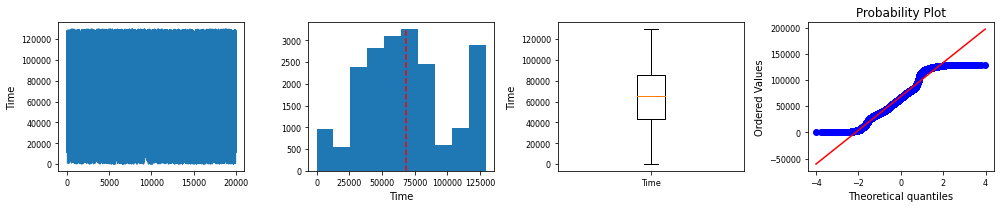

myplots Time


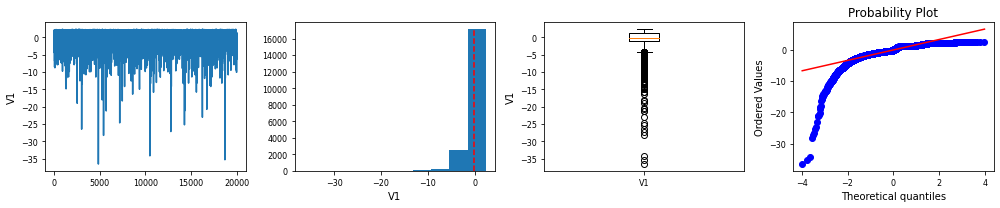

myplots V1


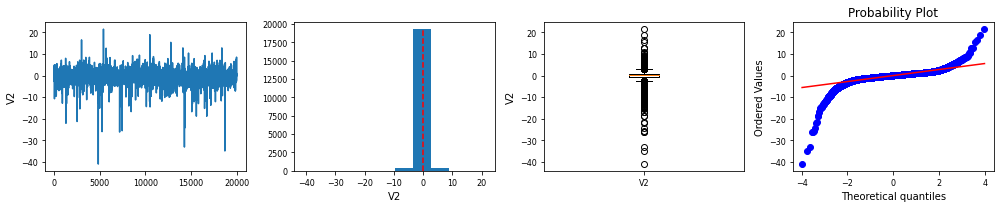

myplots V2


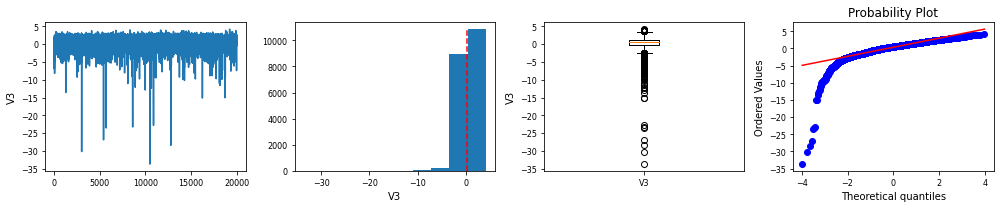

myplots V3


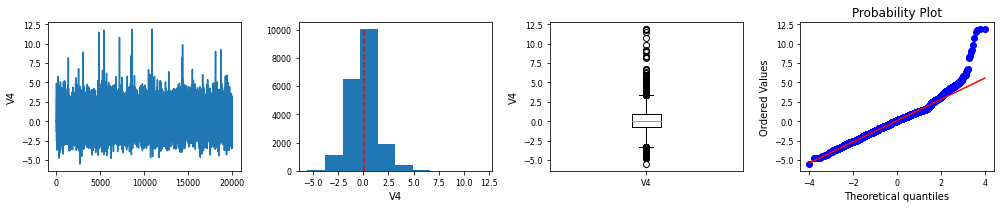

myplots V4


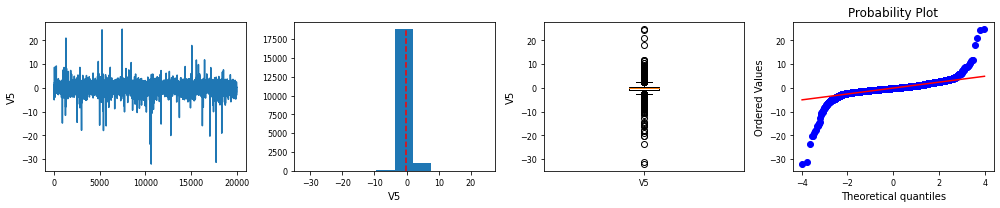

myplots V5


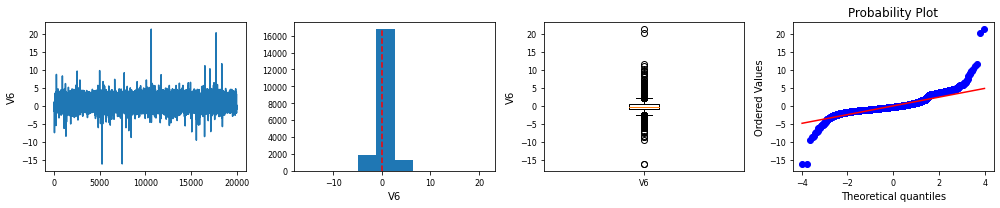

myplots V6


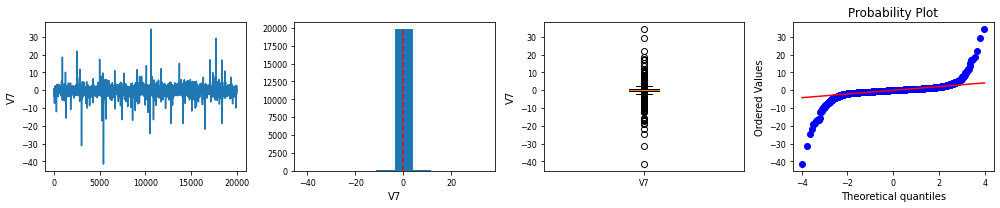

myplots V7


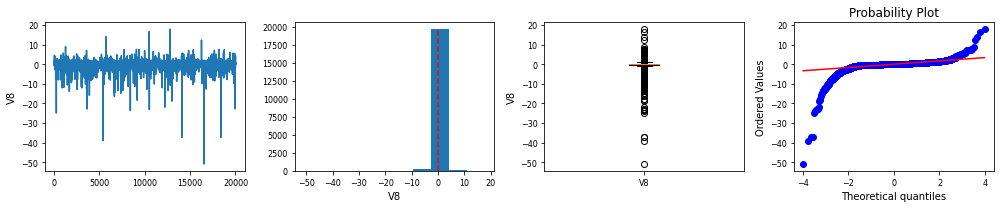

myplots V8


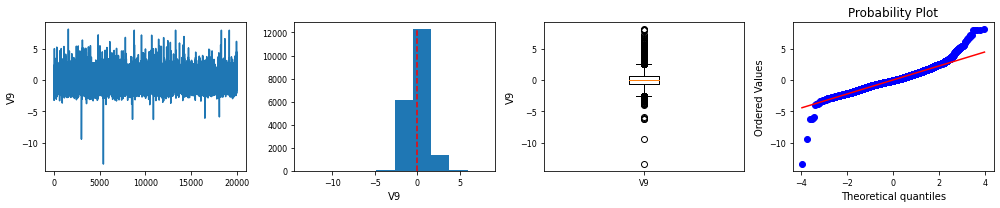

myplots V9


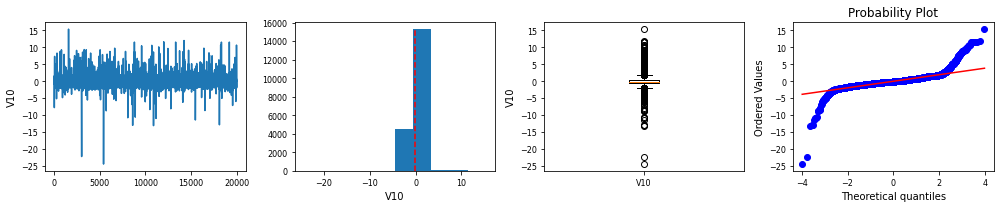

myplots V10


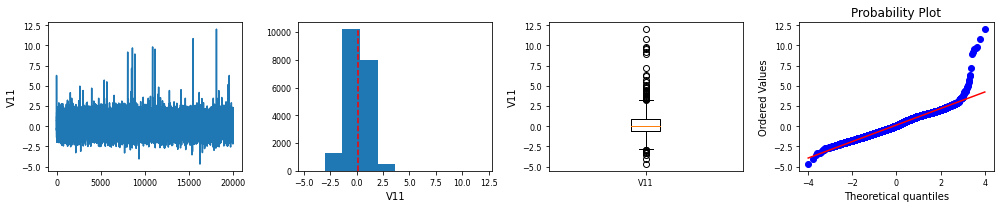

myplots V11


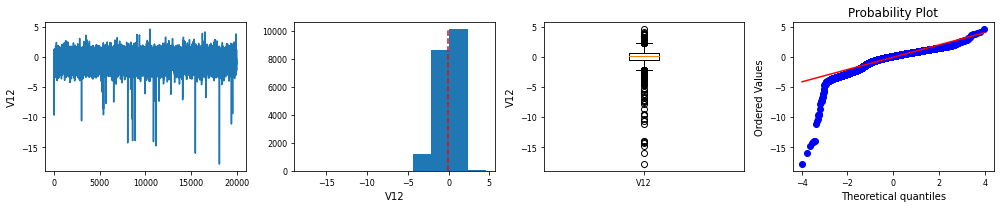

myplots V12


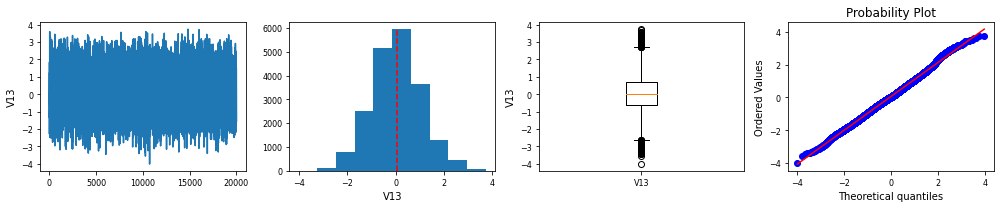

myplots V13


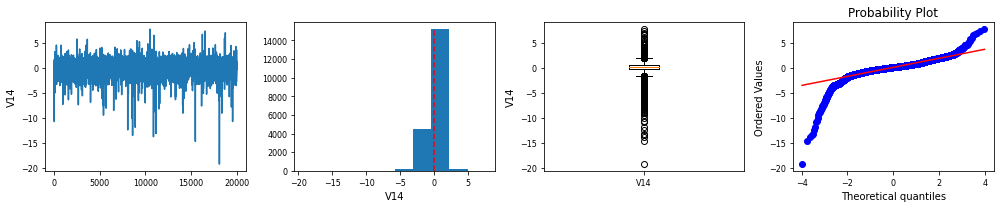

myplots V14


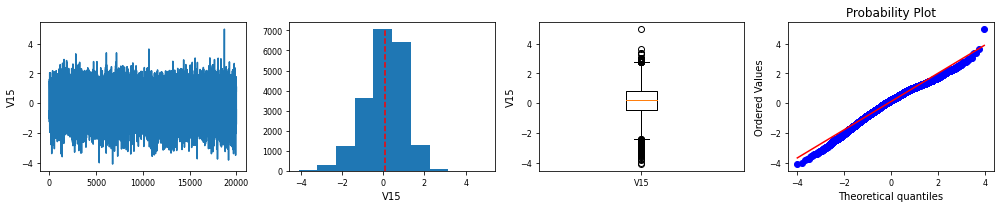

myplots V15


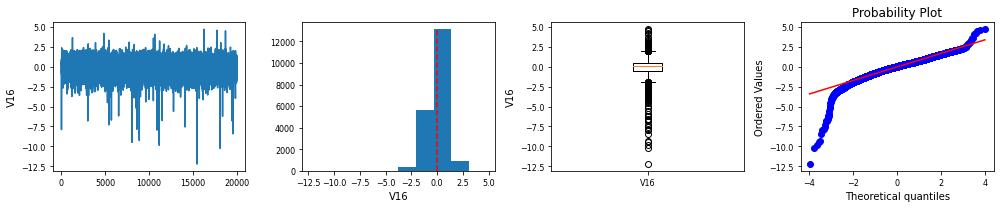

myplots V16


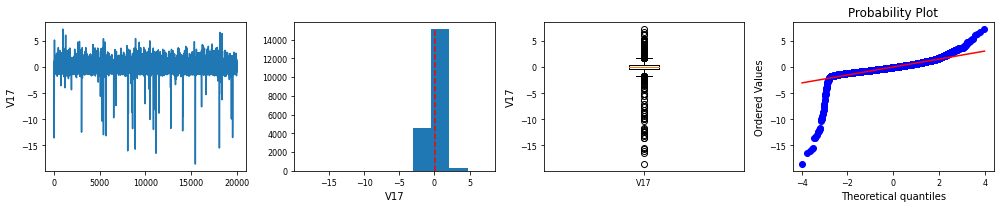

myplots V17


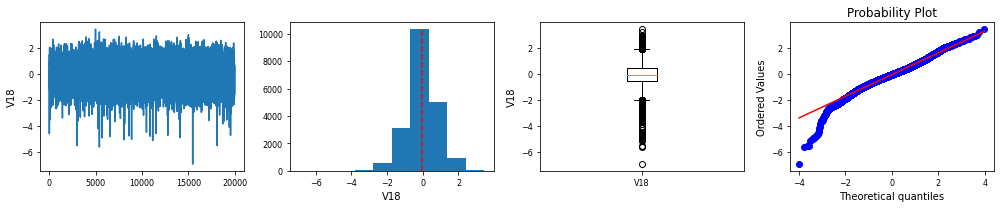

myplots V18


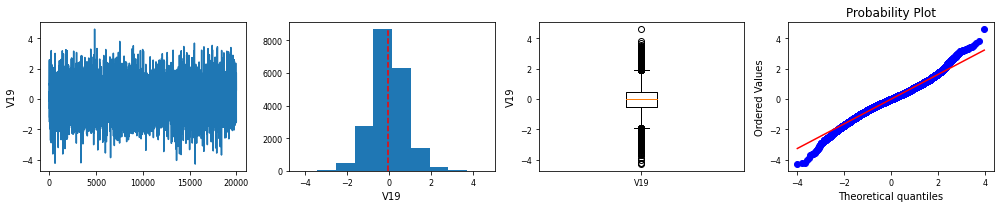

myplots V19


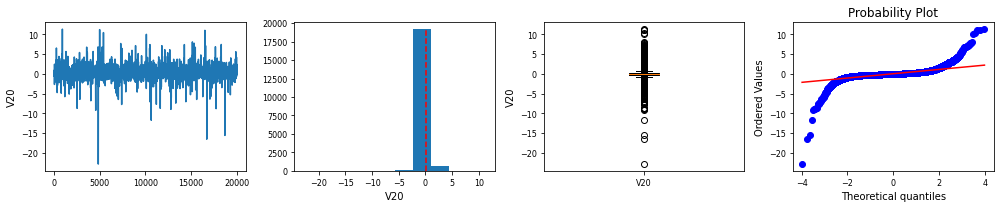

myplots V20


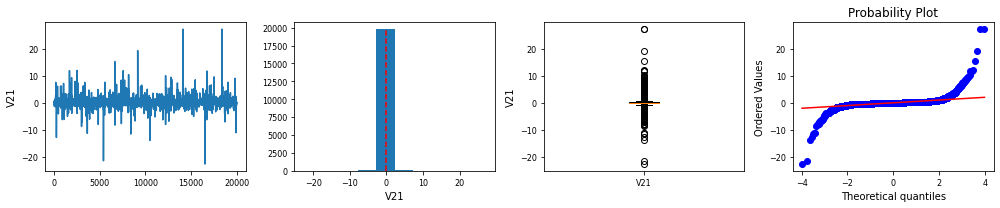

myplots V21


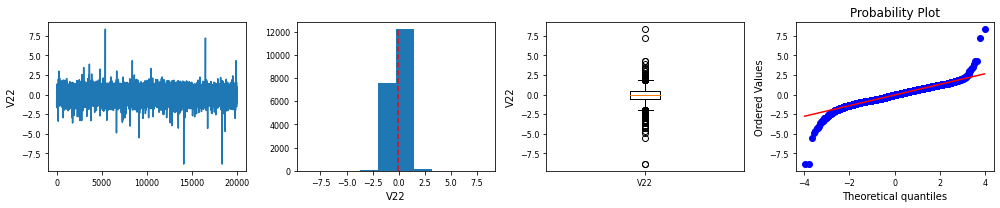

myplots V22


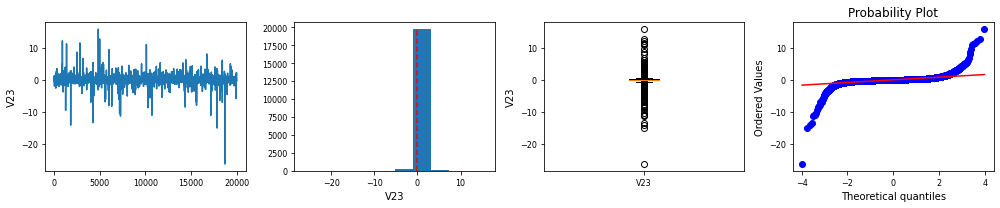

myplots V23


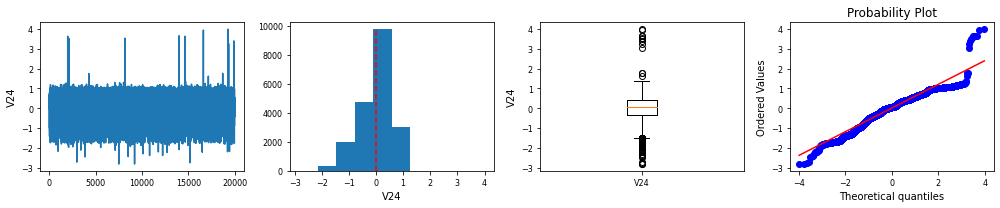

myplots V24


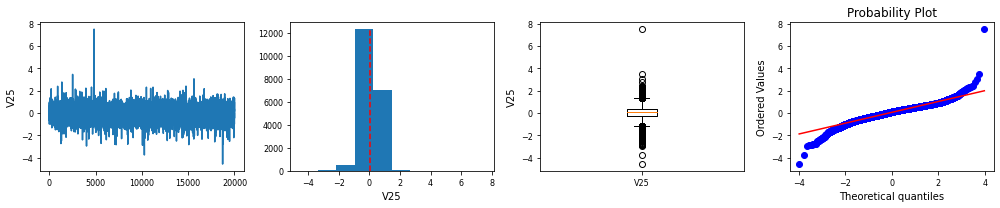

myplots V25


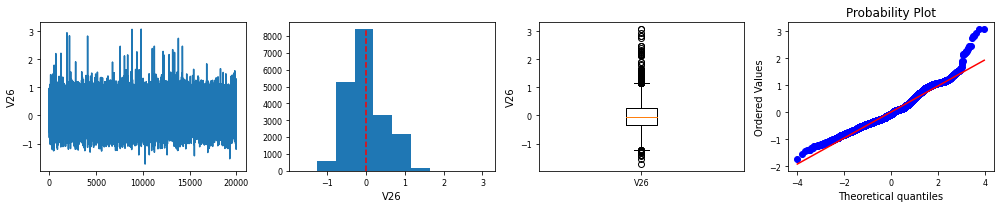

myplots V26


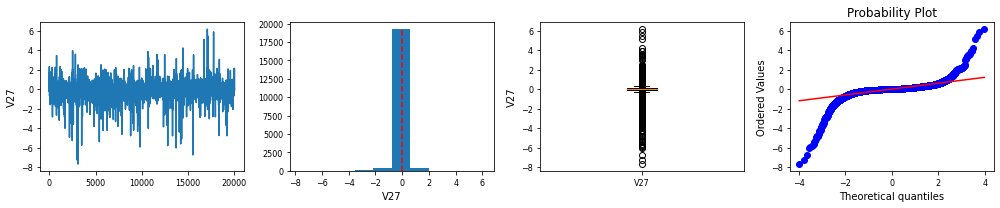

myplots V27


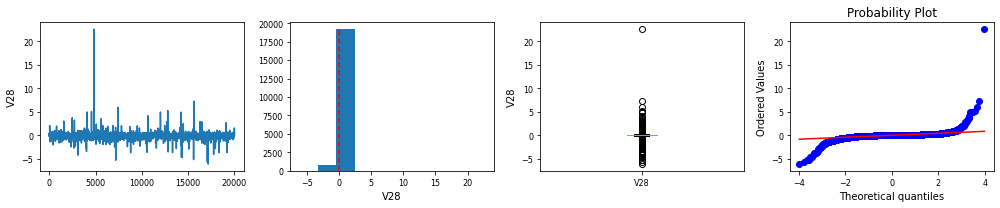

myplots V28


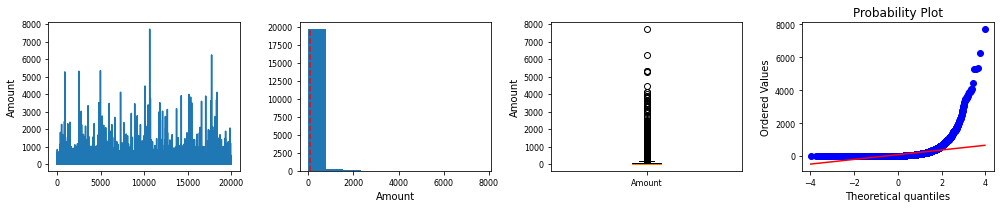

myplots Amount


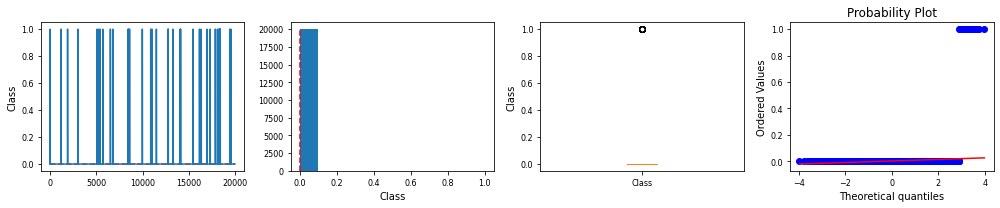

myplots Class


In [58]:
""" TODO
Display the distributions of the data
use visualize.featureplots(crime_stats_dropna.values, crime_stats.columns)
to generate trace plots, histograms, boxplots, and probability plots for
each feature.

A probability plot is used to evaulate the normality of a distribution.
The data are plotted against a theoritical distribution, such that if the data 
are normal, they'll follow the diagonal line. See the reference above for 
more information.
"""
crime_stats_dropna = crime_stats.dropna()
# TODO: visualize the features
visualize.featureplots(crime_stats_dropna.values, crime_stats.columns)

# Right click to enable scrolling

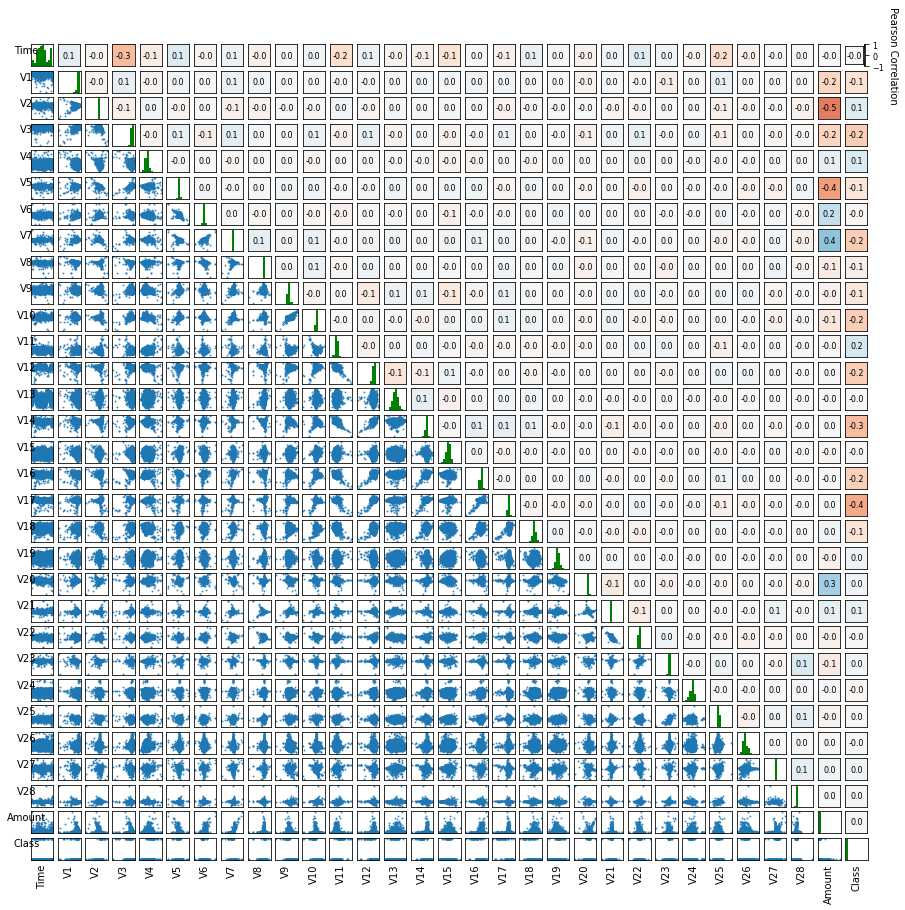

In [59]:
""" PROVIDED
Display the Pearson correlation between all pairs of the features
use visualize.scatter_corrplots(crime_stats_dropna.values, crime_stats.columns, corrfmt="%.1f", FIGW=15)
"""
visualize.scatter_corrplots(crime_stats_dropna.values, crime_stats.columns, corrfmt="%.1f", FIGW=15)

In [60]:
""" PROVIDED
Separate the postive and negative examples
"""
pos = crime_stats.loc[crime_stats['Class'] == 1] 
neg = crime_stats.loc[crime_stats['Class'] == 0] 
print(neg)
pos.shape, neg.shape

            Time         V1        V2        V3        V4        V5        V6  \
163072  115626.0   2.117349 -0.147794 -1.619695 -0.019813  0.565325 -0.110829   
187313  127477.0  -1.676769  1.430974  1.000076  0.964303 -0.743985  0.649634   
106323   69921.0   0.904054 -0.833540  0.994663  0.114879 -0.906469  0.901023   
147048   88069.0  -0.774190 -0.185383  0.301806 -0.105045  1.177323 -1.485653   
113040   72904.0  -0.011294  0.986686  1.170435  0.637556  0.138174 -0.371859   
...          ...        ...       ...       ...       ...       ...       ...   
87044    61516.0   1.192272  0.689974  0.083435  2.434251  0.367766 -0.375974   
155270  104966.0 -10.051169  8.522385 -7.437705 -2.205295 -3.103599 -1.924618   
52564    45531.0  -0.511896 -0.629623  2.096091 -2.308996 -0.964120 -0.974706   
131788   79735.0  -1.031710  0.509037  2.625745  2.245151 -0.771999  0.346881   
122135   76448.0   1.282645  0.175396 -0.305823  0.991152  0.317801  0.088096   

              V7        V8 

((37, 31), (19962, 31))

In [61]:
""" PROVIDED
Compute the postive fraction
"""
pos_fraction = pos.shape[0] / nRows
neg_fraction = 1 - pos_fraction

pos_fraction, neg_fraction

(0.00019288112267239402, 0.9998071188773276)

''

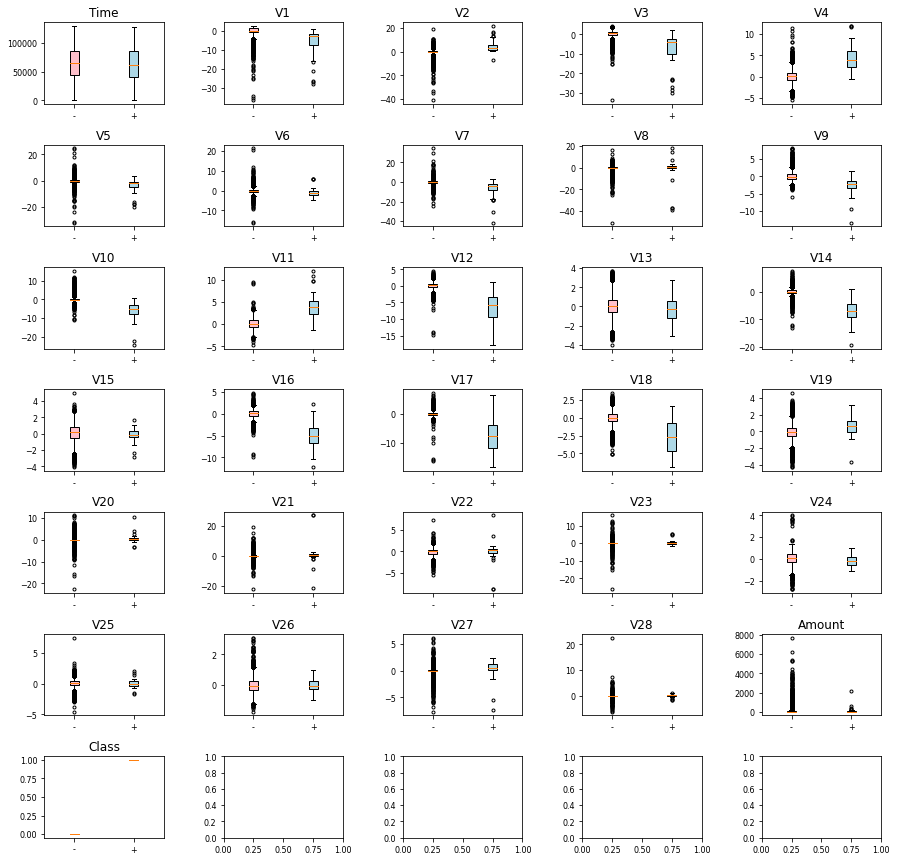

In [62]:
""" PROVIDED
Compare the features for the positive and negative examples
"""
features_displayed = pos.columns
ndisplayed = len(features_displayed)
ncols = 5
nrows = ceil(ndisplayed / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))
fig.subplots_adjust(wspace=.5, hspace=.5)
axs = axs.ravel()
for ax, feat_name in zip(axs, features_displayed):
    boxplot = ax.boxplot([neg[feat_name], pos[feat_name]], patch_artist=True, sym='.')
    boxplot['boxes'][0].set_facecolor('pink')
    boxplot['boxes'][1].set_facecolor('lightblue')
    ax.set_xticklabels(['-', '+'])
    ax.set(title=feat_name)
""""""

# PRE-PROCESS DATA

## Data Clean Up and Feature Selection

In [63]:
""" PROVIDED
Construct Pipeline to pre-process data
"""
feature_names = crime_stats.columns.drop(['Class'])
pipe_X = Pipeline([
    ("NaNrowDropper", DataSampleDropper()),
    ("selectAttribs", DataFrameSelector(feature_names)),
    ("scaler", RobustScaler())
])

pipe_y = Pipeline([
    ("NaNrowDropper", DataSampleDropper()),
    ("selectAttribs", DataFrameSelector(['Class']))
])

In [64]:
""" TODO
Pre-process the data using the pipeliine
"""
X = pipe_X.fit_transform(crime_stats)
y = pipe_y.fit_transform(crime_stats)


np.any(np.isnan(X))

False

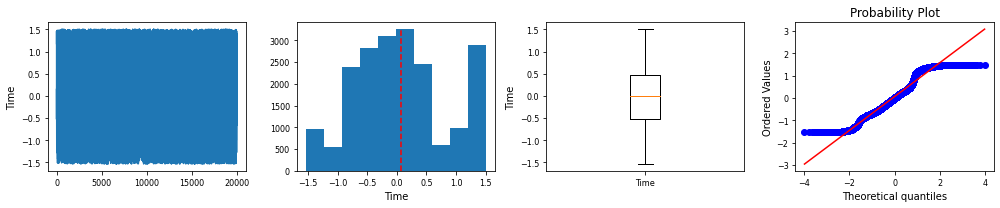

myplots Time


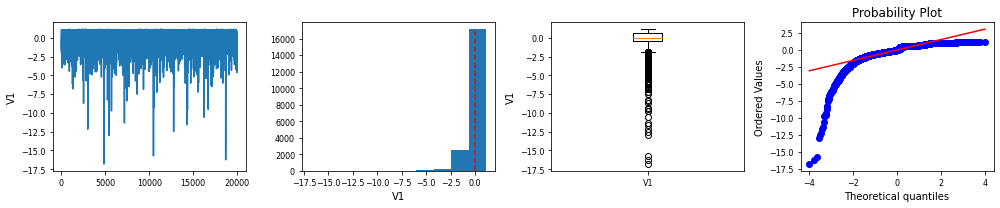

myplots V1


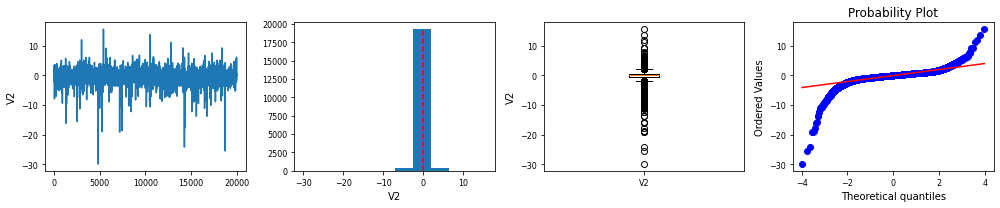

myplots V2


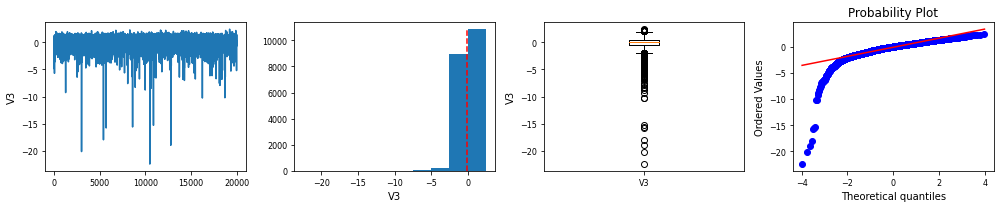

myplots V3


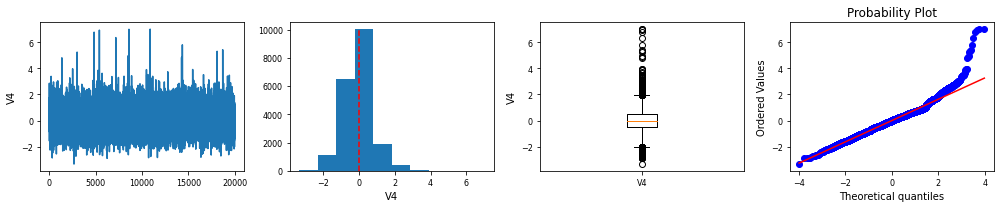

myplots V4


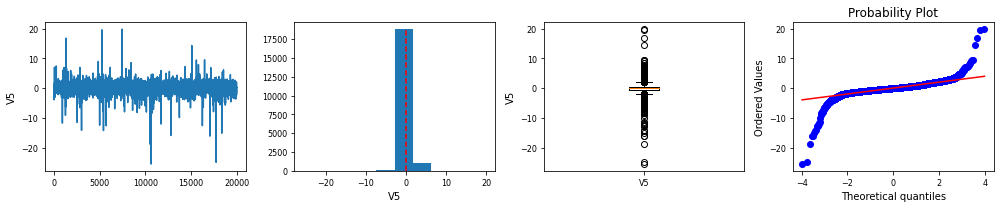

myplots V5


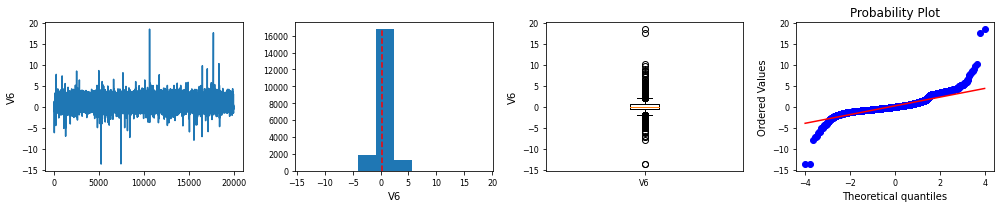

myplots V6


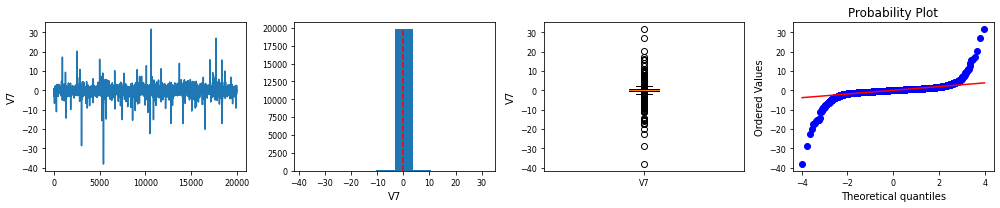

myplots V7


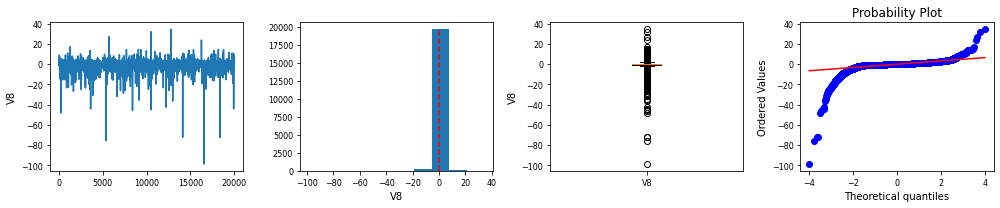

myplots V8


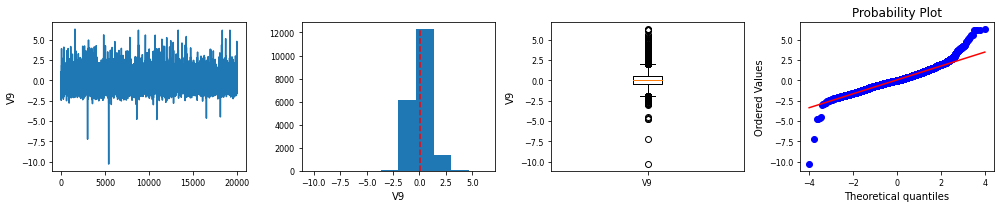

myplots V9


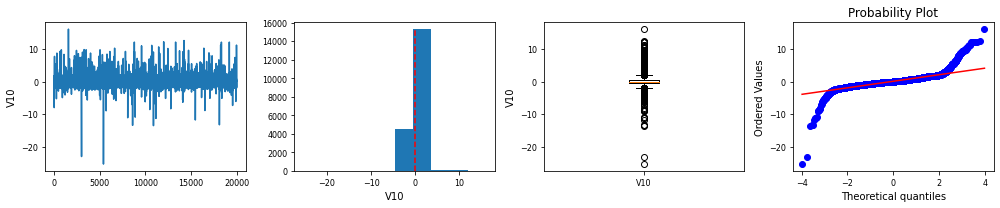

myplots V10


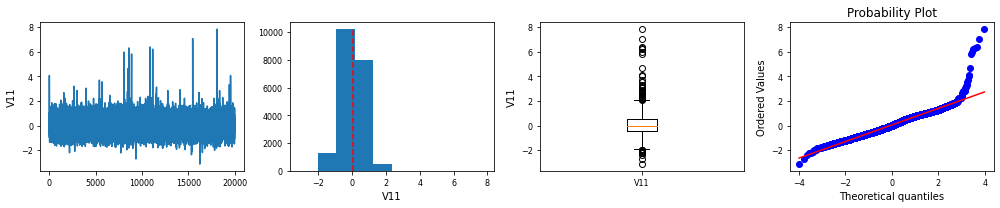

myplots V11


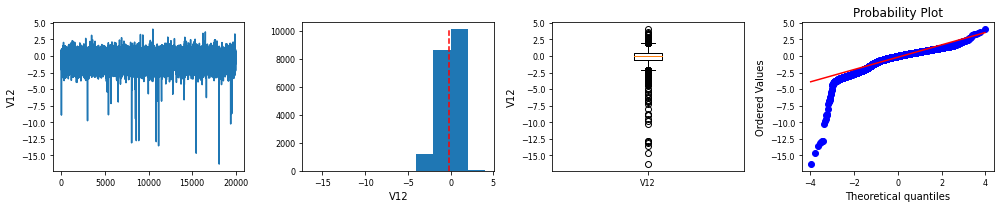

myplots V12


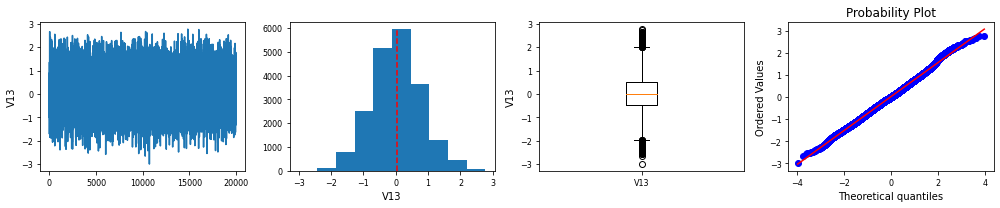

myplots V13


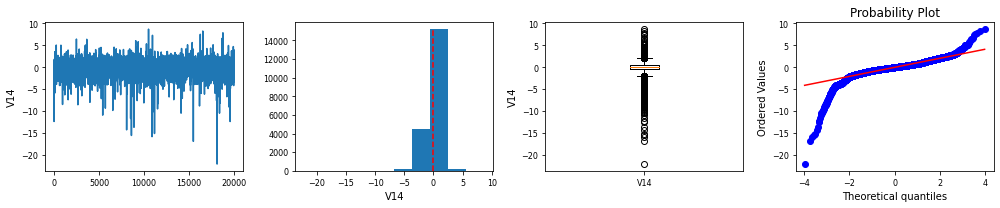

myplots V14


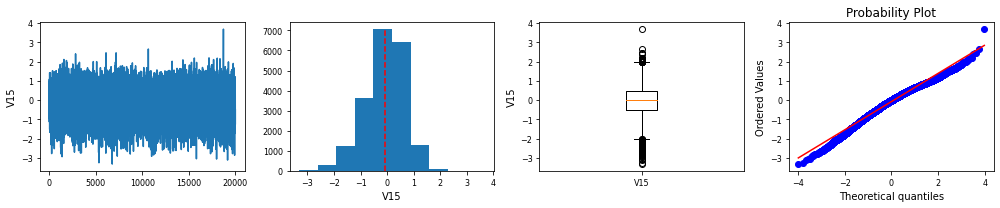

myplots V15


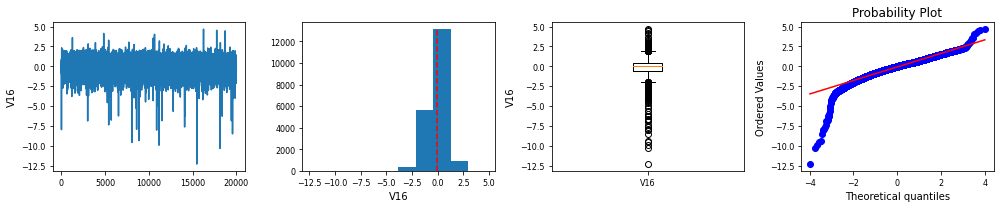

myplots V16


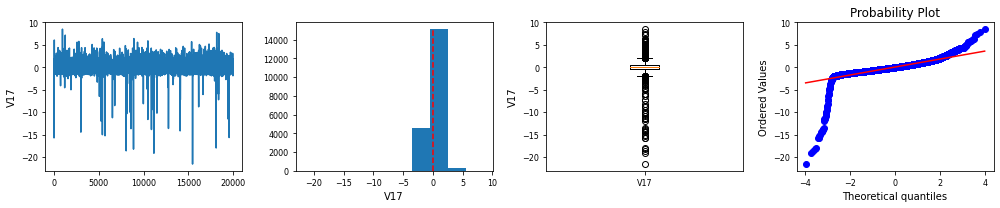

myplots V17


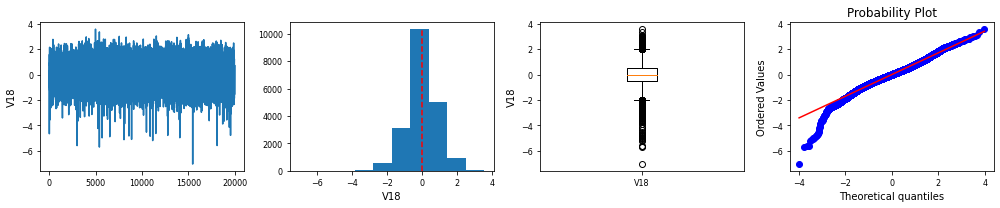

myplots V18


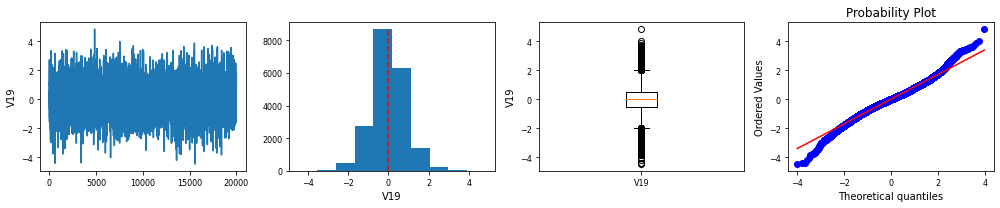

myplots V19


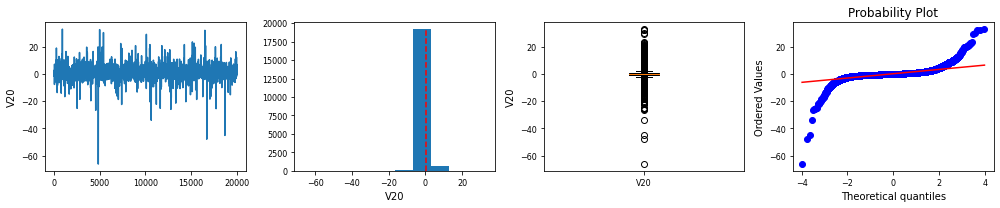

myplots V20


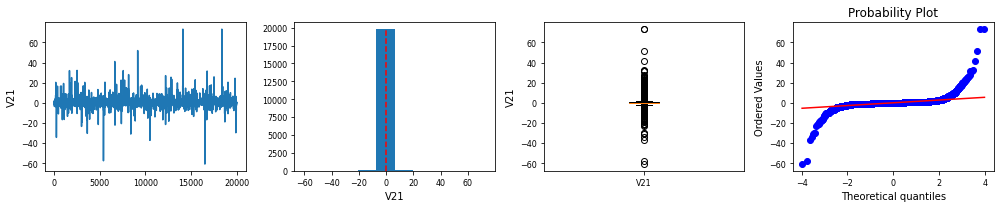

myplots V21


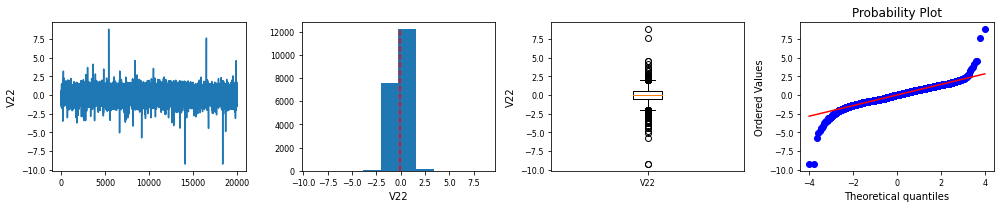

myplots V22


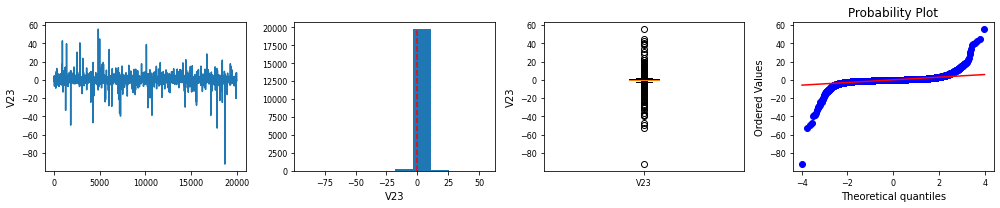

myplots V23


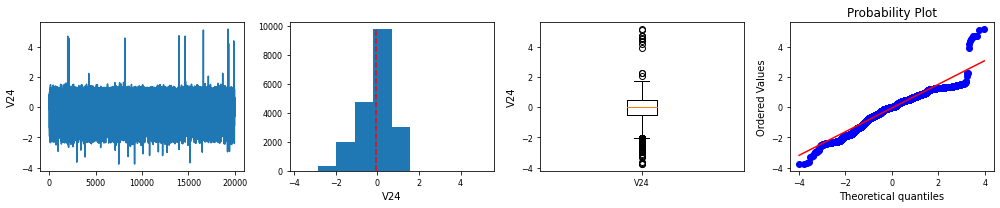

myplots V24


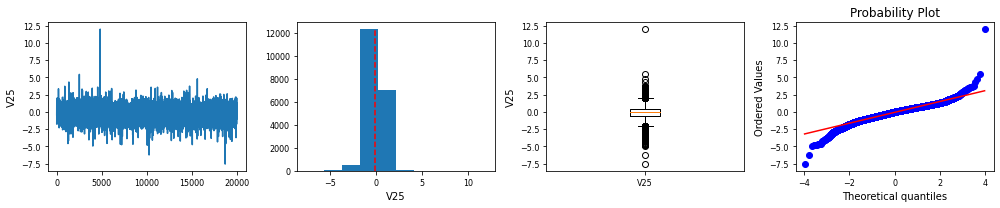

myplots V25


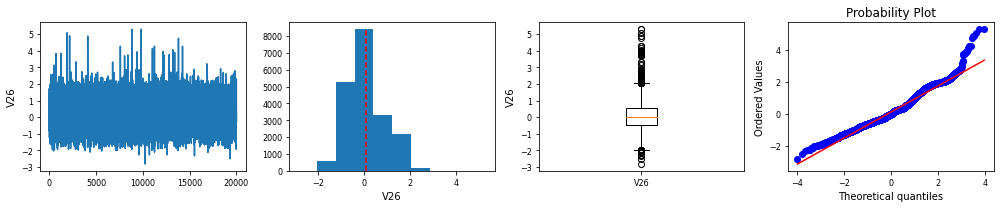

myplots V26


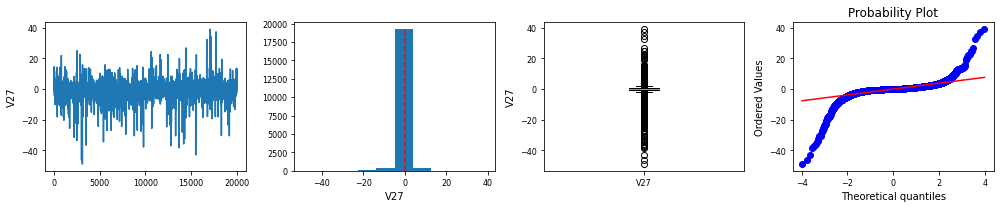

myplots V27


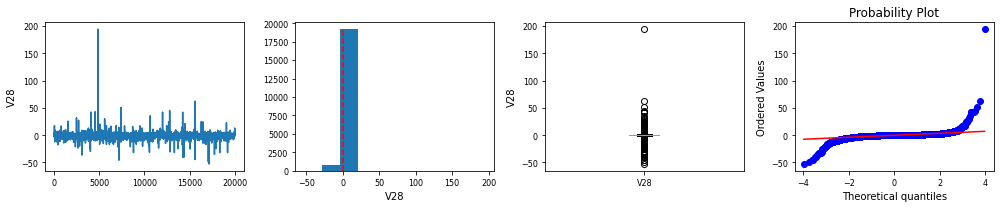

myplots V28


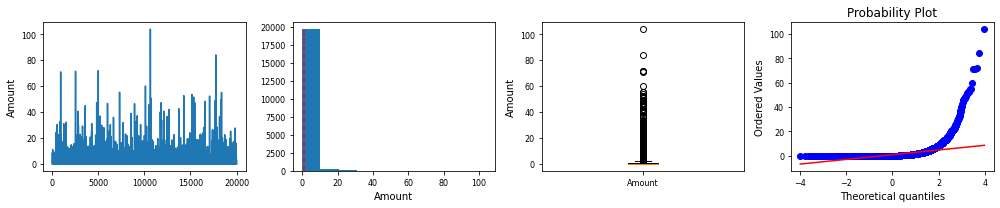

myplots Amount


In [65]:
""" TODO
Re-visualize the pre-processed data
use visualize.featureplots()
"""
visualize.featureplots(X, feature_names)


# SVMs: EXPLORATION

In [66]:
""" TODO
Hold out a subset of the data, before training and cross validation
using train_test_split, with stratify NOT equal to None, and a test_size 
fraction of .2.

For this exploratory section, the held out set of data is a validation set.
For the GridSearch section, the held out set of data is a test set.
"""
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify=y)

In [67]:
""" TODO
Create and train SVC models. 
Explore various configurations of the hyper-parameters. 
Train the models on the training set and evaluate them for the training and
validation sets.

Play around with C, gamma, and class_weight. Feel free to play with other hyper-
parameters as well. See the API for more details.
C is a regularization parameter, gamma is the inverse of the radius of influence
of the support vectors (i.e. lower gamma means a higher radius of influence of the 
support vectors), and class weight determines whether to adjust the weights inversely
to the class fractions.
"""
model = SVC(C=1.0, class_weight='balanced', gamma='scale')
model.fit(Xtrain, np.ravel(ytrain))

SVC(class_weight='balanced')

ROC AUC: 0.999939466048803
PRC AUC: 0.9079505845485083
PSS: 0.9987
F1 Score 0.7500


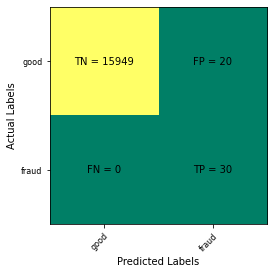

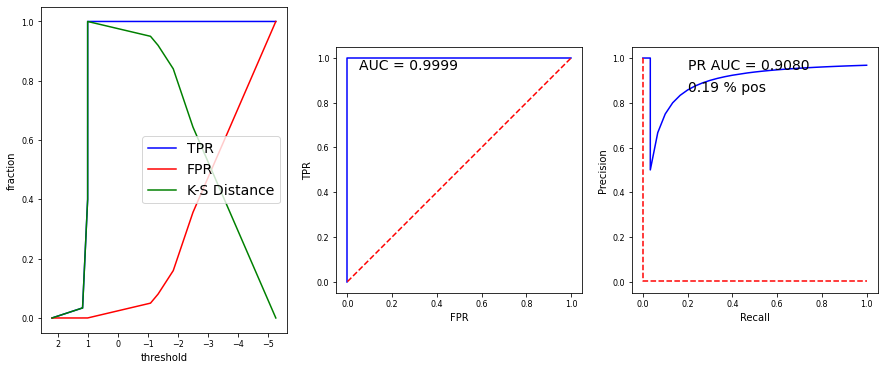

In [68]:
""" TODO
Evaluate training set performance. 
Display the confusion matrix, KS plot with
the cumulative distributions of the TPR and FPR, the ROC curve and the 
precision-recall curve (PRC). use metrics_plots.ks_roc_prc_plot(ytrue, scores)

The PRC, unlike the AUC, does not consider the true negative (i.e. TN) counts,
making the PRC more robust to unbalanced datasets.
"""
# TODO: Confusion matrix
# First, compute the predictions for the training set
# Second, use confusion_matrix
# Third, use metrics_plots.confusion_mtx_colormap() to display the matrix

preds = model.predict(Xtrain)
confusion = confusion_matrix(ytrain, preds)
metrics_plots.confusion_mtx_colormap(confusion, targetnames, targetnames)
# TODO: Curves
# First, use the model's decision function to compute the scores
# Second, use metrics_plots.ks_roc_prc_plot() to display the KS plot, ROC, and PRC
scores = model.decision_function(Xtrain)
metrics_plots.ks_roc_prc_plot(ytrain, scores)


pss_train = metrics_plots.skillScore(ytrain.values, preds)
f1_train = f1_score(ytrain.values.ravel(), preds)
print("PSS: %.4f" % pss_train[0])
print("F1 Score %.4f" % f1_train)

ROC AUC: 0.9830059747415119
PRC AUC: 0.4815594127620515
PSS: 0.2855
F1 Score 0.4000


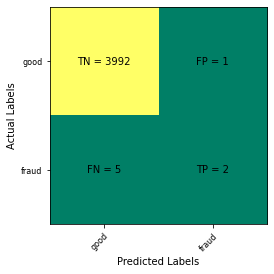

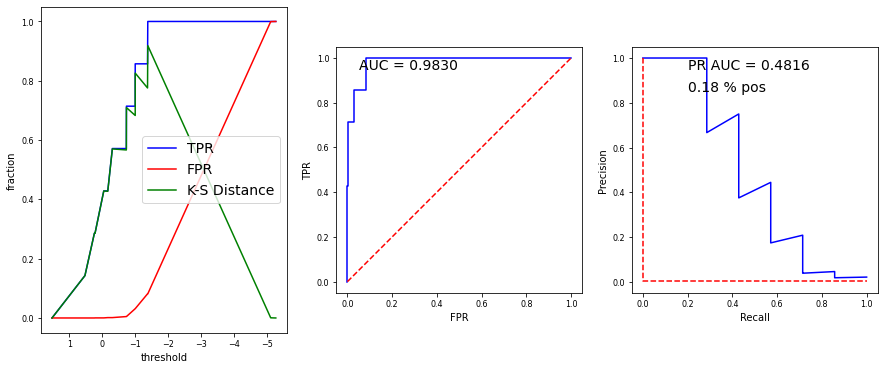

In [69]:
""" TODO
Evaluate validation performance. 
Display the confusion matrix, KS plot with the cumulative distributions of the TPR 
and FPR, the ROC curve and the precision-recall curve (PRC).
"""
# TODO: Confusion matrix
preds_test = model.predict(Xtest)
confusion = confusion_matrix(ytest, preds_test)
metrics_plots.confusion_mtx_colormap(confusion, targetnames, targetnames)


# TODO: Curves
test_scores = model.decision_function(Xtest)
metrics_plots.ks_roc_prc_plot(ytest, test_scores)



pss_test = metrics_plots.skillScore(ytest.values, preds_test)
f1_test = f1_score(ytest.values.ravel(), preds_test)
print("PSS: %.4f" % pss_test[0])
print("F1 Score %.4f" % f1_test)

# SVMs: STRATIFIED GRID SEARCH

## Scorers

In [70]:
""" PROVIDED
List of available scoring functions from the sklearn module
"""
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

## Execute Grid Search

In [71]:
""" TODO
Estimated time: <30 min on mlserver
Set up and run the grid search using GridSearchCV and the following 
settings:
* SVC for the model,
* The above scoring dictionary for scoring,
* refit set to 'f1' as the optimized metric
* Three for the number of cv folds, 
* n_jobs=-1, 
* verbose=2, 
* return_train_score=True
"""
# Optimized metric
opt_metric = 'f1'
scoring = {opt_metric:opt_metric}

# Flag to re-load previous run
force = False
# File previous run is saved to
srchfname = "hw8_search_" + opt_metric + ".pkl"

# SETUP EXPERIMENT HYPERPARAMETERS
Cs = [.5, 1, 10, 100, 200]
gammas = np.logspace(-4, 0, num=5, endpoint=True, base=5)

nCs = len(Cs)
ngammas = len(gammas)

hyperparams = {'C':Cs, 'gamma':gammas, 'tol':[1e-4],
               'class_weight':[None, 'balanced']}

# RUN EXPERIMENT
time0 = timelib.time()
search = None
if force or (not os.path.exists(srchfname)):
    # TODO: Create the GridSearchCV object
    search = GridSearchCV(model,hyperparams, scoring=scoring, refit=opt_metric, cv=3, n_jobs=-1, verbose=2, return_train_score=True)
    
    # TODO: Execute the grid search by calling fit using the training data
    search.fit(Xtrain, ytrain)
    
    # TODO: Save the grid search object
    joblib.dump(search, srchfname)
    
    print("Saved %s" % srchfname)
else:
    search = joblib.load(srchfname)
    print("Loaded %s" % srchfname)

time1 = timelib.time()
duration = time1 - time0
print("Elapsed Time: %.2f min" % (duration / 60))

search

Loaded hw8_search_f1.pkl
Elapsed Time: 0.00 min


GridSearchCV(cv=3, estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [0.5, 1, 10, 100, 200],
                         'class_weight': [None, 'balanced'],
                         'gamma': array([0.0016, 0.008 , 0.04  , 0.2   , 1.    ]),
                         'tol': [0.0001]},
             refit='f1', return_train_score=True, scoring={'f1': 'f1'},
             verbose=2)

# RESULTS

In [72]:
""" PROVIDED
Display the head of the results for the grid search
See the cv_results_ attribute
"""
all_results = search.cv_results_
df_res = pd.DataFrame(all_results)
df_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_gamma,param_tol,params,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,mean_train_f1,std_train_f1
0,0.160613,0.021081,0.043233,0.002872,0.5,None,0.0016,0.0001,"{'C': 0.5, 'class_weight': None, 'gamma': 0.00...",0.666667,0.545455,0.666667,0.626263,0.05714,6,0.785714,0.714286,0.758621,0.752874,0.029442
1,0.286437,0.053147,0.102120,0.010811,0.5,None,0.008,0.0001,"{'C': 0.5, 'class_weight': None, 'gamma': 0.00...",0.181818,0.000000,0.000000,0.060606,0.08571,36,0.720000,0.476190,0.476190,0.557460,0.114933
2,0.845721,0.056265,0.345715,0.031789,0.5,None,0.04,0.0001,"{'C': 0.5, 'class_weight': None, 'gamma': 0.04...",0.000000,0.000000,0.000000,0.000000,0.00000,37,0.000000,0.222222,0.222222,0.148148,0.104757
3,5.129018,0.149945,1.571507,0.036142,0.5,None,0.2,0.0001,"{'C': 0.5, 'class_weight': None, 'gamma': 0.2,...",0.000000,0.000000,0.000000,0.000000,0.00000,37,0.000000,0.222222,0.222222,0.148148,0.104757
4,14.821111,0.538903,3.403871,0.147670,0.5,None,1,0.0001,"{'C': 0.5, 'class_weight': None, 'gamma': 1.0,...",0.000000,0.000000,0.000000,0.000000,0.00000,37,0.000000,0.222222,0.222222,0.148148,0.104757


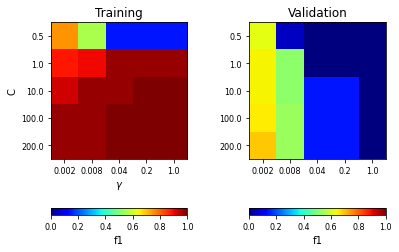

In [73]:
""" PROVIDED
Plot the mean training and validation results from the grid search as a
colormap, for C (y-axis) vs the gamma (x-axis), for class_weight=None
"""
results_grid_train = df_res['mean_train_'+opt_metric].values.reshape(nCs, 2, ngammas)
results_grid_val = df_res['mean_test_'+opt_metric].values.reshape(nCs, 2, ngammas)

fig, axs = plt.subplots(1, 2, figsize=(6,6))
fig.subplots_adjust(wspace=.45)
axs = axs.ravel()
means = [("Training", results_grid_train),
         ("Validation", results_grid_val)]
for i, (name, result) in enumerate(means):
    img = axs[i].imshow(result[:,0,:], cmap="jet", vmin=0, vmax=1)
    axs[i].set_title(name)
    axs[i].set_xticks(range(ngammas))
    axs[i].set_yticks(range(nCs))
    axs[i].set_xticklabels(np.around(gammas, 3))
    axs[i].set_yticklabels(np.around(Cs, 3))
    axs[i].figure.colorbar(img, ax=axs[i], label=opt_metric, 
                           orientation='horizontal')
    if i == 0:
        axs[i].set_xlabel(r"$\gamma$")
        axs[i].set_ylabel("C")
#fig.suptitle('class_weight=None')

In [74]:
""" TODO
Obtain the best model from the grid search and 
fit it to the full training data
"""
best_model = search.best_estimator_
best_model.fit(Xtrain, np.ravel(ytrain))


SVC(C=0.5, class_weight='balanced', gamma=0.0016, tol=0.0001)

ROC AUC: 0.9996639322019747
PRC AUC: 0.8279366371873739
PSS: 0.9647
F1 Score 0.6374


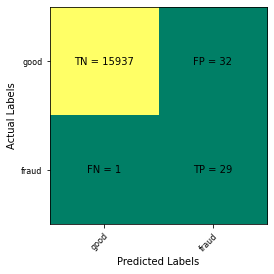

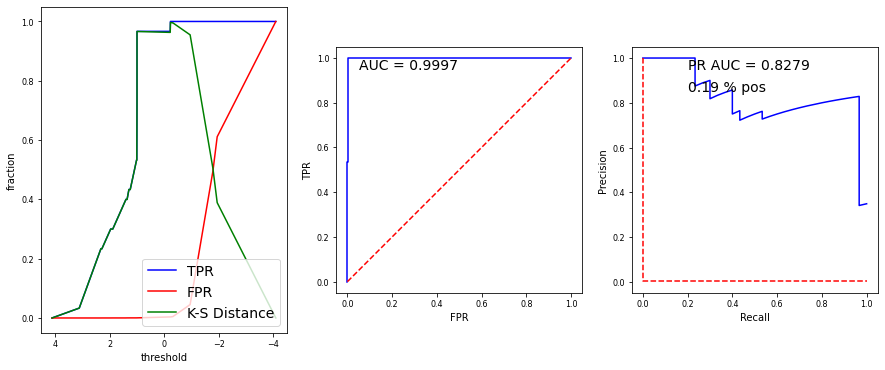

In [75]:
""" TODO
For the best model, display the confusion matrix, KS plot, ROC curve, 
and PR curve for the training set
"""
# TODO: Confusion Matrix
preds = best_model.predict(Xtrain)
confusion = confusion_matrix(ytrain, preds)
metrics_plots.confusion_mtx_colormap(confusion, targetnames, targetnames)


# TODO: Curves
best_scores = best_model.decision_function(Xtrain)
metrics_plots.ks_roc_prc_plot(ytrain, best_scores)




pss_res = metrics_plots.skillScore(ytrain.values, preds)
f1_res = f1_score(ytrain.values.ravel(), preds)
print("PSS: %.4f" % pss_res[0])
print("F1 Score %.4f" % f1_res)

ROC AUC: 0.8943150513398448
PRC AUC: 0.6617552917226903
PSS: 0.7128
F1 Score 0.5556


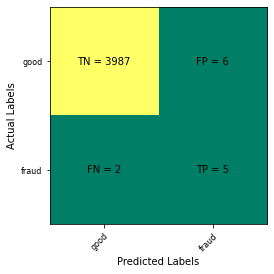

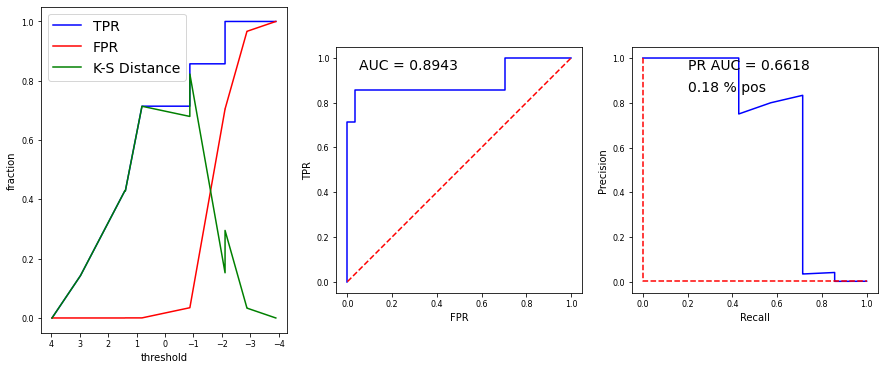

In [76]:
""" TODO
For the best model, display the confusion matrix, KS plot, ROC curve, 
and PR curve for the test set
"""
# TODO: Confusion Matrix
preds_test = best_model.predict(Xtest)
confusion = confusion_matrix(ytest, preds_test)
metrics_plots.confusion_mtx_colormap(confusion, targetnames, targetnames)


# TODO: Curves
best_scores = best_model.decision_function(Xtest)
metrics_plots.ks_roc_prc_plot(ytest, best_scores)




pss_res_test = metrics_plots.skillScore(ytest.values, preds_test)
f1_res_test = f1_score(ytest.values.ravel(), preds_test)
print("PSS: %.4f" % pss_res_test[0])
print("F1 Score %.4f" % f1_res_test)

[Text(0.5, 1.0, 'Scores pos example vs neg example')]

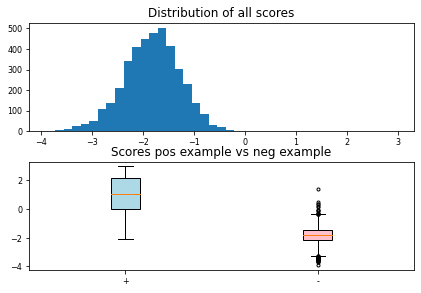

In [152]:
""" TODO
Plot a histogram of the test scores from the best model.
Compare the distribution of scores for positive and negative examples
using boxplots.

Create one subplot of the distribution of all the scores, with a histogram. 
Create a second subplot comparing the distribution of the scores of the 
positive examples with the distribution of the negative examples, with boxplots.
"""
# TODO: Obtain the indices of the pos and neg examples
pos_indices = np.where(ytest['Class'] == 1)
neg_indices = np.where(ytest['Class'] == 0)

# TODO: Separate the scores for the pos and neg examples
pos = np.take(best_scores, list(pos_indices[0]))
neg = np.take(best_scores, list(neg_indices[0]))


# TODO: Plot the distribution of all scores
fig, axs = plt.subplots(2)
fig.tight_layout()
nbins = 41
axs[0].hist(best_scores, bins=nbins)
axs[0].set(title='Distribution of all scores')

# TODO: Plot the boxplots of the pos and neg examples' scores
boxplot = axs[1].boxplot([pos, neg], patch_artist=True, sym='.')
boxplot['boxes'][0].set_facecolor('lightblue')
boxplot['boxes'][1].set_facecolor('pink')
axs[1].set_xticklabels(['+', '-'])
axs[1].set(title='Scores pos example vs neg example')


# Discussion
In a few brief paragraphs, discuss and interpret the test results for the best model. Include a brief discussion of the difference in the meaning of the AUC for the ROC vs the AUC for the PRC. Also, discuss the histogram and boxplots of the scores.

AUC for the ROC is the probability the classifier can accurately differentiate between the two classes. This AUC is is used as a summary for the ROC. The model will better distingush between postive and negative as the AUC gets higher. Althoug this applies to AUC for PRC, PRC does not consider true negatives and will not be affected by the relative imbalance. Using the test results, we see that AUC has a 0.8943, where as PRAUC has 0.6618. As seen from the boxplot and histogram, there are more negative examples than postive. This explains why AUC ROC is better than PRAUC.